This notebook is part of the `deepcell-tf` documentation: https://deepcell.readthedocs.io/.

# Training a segmentation model

`deepcell-tf` leverages [Jupyter Notebooks](https://jupyter.org) in order to train models. Example notebooks are available for most model architectures in the [notebooks folder](https://github.com/vanvalenlab/deepcell-tf/tree/master/notebooks). Most notebooks are structured similarly to this example and thus this notebook serves as a core reference for the deepcell approach to model training.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import peak_local_max
import tensorflow as tf

from deepcell.applications import mesmer
from deepcell.image_generators import CroppingDataGenerator
from deepcell.losses import weighted_categorical_crossentropy
from deepcell.model_zoo.panopticnet import PanopticNet
from deepcell.utils.train_utils import count_gpus, rate_scheduler
from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell_toolbox.metrics import Metrics
from deepcell_toolbox.processing import histogram_normalization
from skimage.transform import resize

## File paths

In [2]:
data_dir = 'tissuenet_v1.1'
#data_dir = 'DynamicNuclearNet-segmentation-v1_0'
model_path = 'Mesmer'
metrics_path = 'metrics.yaml'
train_log = 'train_log.csv'

## Load the data

Loads Tissue net dataset 

In [36]:
data_dir = 'DynamicNuclearNet-segmentation-v1_0'
with np.load(os.path.join(data_dir, 'train.npz')) as data:
    X_train = data['X']
    y_train = data['y']
    
with np.load(os.path.join(data_dir, 'val.npz')) as data:
    X_val = data['X']
    y_val = data['y']
    
with np.load(os.path.join(data_dir, 'test.npz')) as data:
    X_test = data['X']
    y_test = data['y']

In [ ]:
with np.load(os.path.join(data_dir, 'tissuenet_v1.1_train.npz')) as data:
    X_train = data['X']
    y_train = data['y']
    
with np.load(os.path.join(data_dir, 'tissuenet_v1.1_val.npz')) as data:
    X_val = data['X']
    y_val = data['y']
    
with np.load(os.path.join(data_dir, 'tissuenet_v1.1_test.npz')) as data:
    X_test = data['X']
    y_test = data['y']

X contains main images, Y contains segmentation mask 
X and Y train = (2580, 512, 512, 2)
X and Y val = (3118, 256, 256, 2)
X and Y test = (1324, 256, 256, 2)

4th dimension contains membrane and nuclear 

In [37]:
print("Train data shapes:", X_train.shape, "and" ,y_train.shape)
print("Validation data shapes:", X_val.shape, "and" , y_val.shape)
print("Test data shapes:", X_test.shape, "and" , y_test.shape)

Train data shapes: (4950, 512, 512, 1) and (4950, 512, 512, 1)
Validation data shapes: (1417, 512, 512, 1) and (1417, 512, 512, 1)
Test data shapes: (717, 512, 512, 1) and (717, 512, 512, 1)


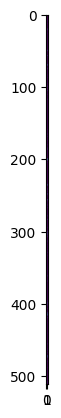

In [5]:
plt.imshow(X_train[0][1])


## Training parameters

The majority of DeepCell models support a variety backbone choices specified in the “backbone” parameter. Backbones are provided through keras_applications and can be instantiated with weights that are pretrained on ImageNet.

In [6]:
# Model architecture
backbone = "efficientnetv2bl"
location = True
pyramid_levels = ["P1","P2","P3","P4","P5","P6","P7"]

In [7]:
# Augmentation and transform parameters
seed = 0
min_objects = 1
zoom_min = 0.75
crop_size = 256
outer_erosion_width = 1
inner_distance_alpha = "auto"
inner_distance_beta = 1
inner_erosion_width = 0

In [8]:
# Post processing parameters
maxima_threshold = 0.1
interior_threshold = 0.01
exclude_border = False
small_objects_threshold = 0
min_distance = 10

In [9]:
# Training configuration
epochs = 16
batch_size = 16
lr = 1e-4

## Create data generators

In [10]:
# data augmentation parameters
zoom_max = 1 / zoom_min

# Preprocess the data
X_train = histogram_normalization(X_train)
X_val = histogram_normalization(X_val)

# use augmentation for training but not validation
datagen = CroppingDataGenerator(
    rotation_range=180,
    zoom_range=(zoom_min, zoom_max),
    horizontal_flip=True,
    vertical_flip=True,
    crop_size=(crop_size, crop_size),
)

datagen_val = CroppingDataGenerator(
    crop_size=(crop_size, crop_size)
)

In [11]:
transforms = ["inner-distance", "outer-distance", "fgbg"]

transforms_kwargs = {
    "outer-distance": {"erosion_width": outer_erosion_width},
    "inner-distance": {
        "alpha": inner_distance_alpha,
        "beta": inner_distance_beta,
        "erosion_width": inner_erosion_width,
    },
}

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    min_objects=min_objects,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    batch_size=batch_size,
)

print("Created training data generator.")

val_data = datagen_val.flow(
    {'X': X_val, 'y': y_val},
    seed=seed,
    min_objects=min_objects,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    batch_size=batch_size,
)

print("Created validation data generator.")

Created training data generator.
Created validation data generator.


In [12]:
train_data.output_size

(256, 256)

In [13]:
val_data.output_size

(256, 256)

Visualize the data generator output.

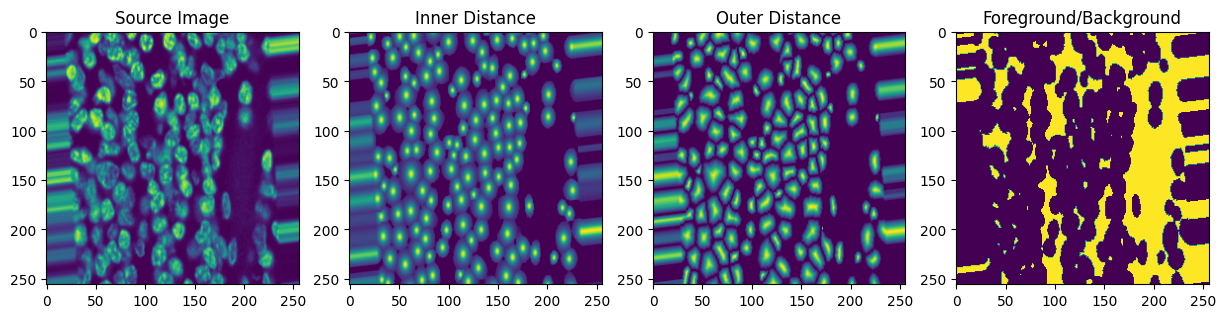

In [14]:
inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

fig, axes = plt.subplots(1, 4, figsize=(15, 15))

axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')

axes[1].imshow(inner_distance[0, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, ..., 0])
axes[3].set_title('Foreground/Background')

plt.show()

## Create the PanopticNet Model

Here we instantiate a `PanopticNet` model from `deepcell.model_zoo` using 3 semantic heads:
inner distance (1 class),
outer distance (1 class),
foreground/background distance (2 classes)

In [15]:
input_shape = (crop_size, crop_size, 1)

model = PanopticNet(
    backbone=backbone,
    input_shape=input_shape,
    norm_method=None,
    num_semantic_classes=[1, 1, 2],  # inner distance, outer distance, fgbg
    location=location, 
    include_top=True,
    backbone_levels=["C1", "C2", "C3", "C4", "C5"],
    pyramid_levels=pyramid_levels,
)

### Create a loss function for each semantic head

Each semantic head is trained with it's own loss function. Mean Square Error is used for regression-based heads, whereas `weighted_categorical_crossentropy` is used for classification heads.

The losses are saved as a dictionary and passed to `model.compile`.

In [16]:
def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes
            )
        return tf.keras.losses.MSE(y_pred, y_true)

    return _semantic_loss

loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith("semantic_"):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=0.001)

model.compile(loss=loss, optimizer=optimizer)

In [27]:
loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith("semantic_"):
        n_classes = layer.output_shape[-1]
        current_loss = semantic_loss(n_classes)
        
        if isinstance(current_loss, dict):
            # If the loss is a dictionary (multiple losses), assign each one
            for key, value in current_loss.items():
                loss[layer.name + '_' + key] = value
        else:
            # If the loss is a single value, assign it
            loss[layer.name] = current_loss

# Check if all outputs have associated losses
for output_name in model.output_names:
    if output_name not in loss:
        raise ValueError(f"No loss specified for output: {output_name}")

optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=0.001)

model.compile(loss=loss, optimizer=optimizer)

In [31]:
loss["semantic_1"]

<function __main__.semantic_loss.<locals>._semantic_loss(y_true, y_pred)>

## Train the model

Call `fit` on the compiled model, along with a default set of callbacks.

In [32]:
# Clear clutter from previous TensorFlow graphs.
tf.keras.backend.clear_session()

monitor = "val_loss"

csv_logger = tf.keras.callbacks.CSVLogger(train_log)

# Create callbacks for early stopping and pruning.
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        model_path,
        monitor=monitor,
        save_best_only=True,
        verbose=1,
        save_weights_only=False,
    ),
    tf.keras.callbacks.LearningRateScheduler(rate_scheduler(lr=lr, decay=0.99)),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor=monitor,
        factor=0.1,
        patience=5,
        verbose=1,
        mode="auto",
        min_delta=0.0001,
        cooldown=0,
        min_lr=0,
    ),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    csv_logger,
]

print(f"Training on {count_gpus()} GPUs.")

# Train model.
history = model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=epochs,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=callbacks,
)

print("Final", monitor, ":", history.history[monitor][-1])

Training on 0 GPUs.
Epoch 1/16


ValueError: in user code:

    File "c:\Users\miles\GitHub\mesmer-implementation\.venv\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\miles\GitHub\mesmer-implementation\.venv\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\miles\GitHub\mesmer-implementation\.venv\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\miles\GitHub\mesmer-implementation\.venv\lib\site-packages\keras\engine\training.py", line 864, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\miles\GitHub\mesmer-implementation\.venv\lib\site-packages\keras\engine\training.py", line 957, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\miles\GitHub\mesmer-implementation\.venv\lib\site-packages\keras\engine\compile_utils.py", line 438, in update_state
        self.build(y_pred, y_true)
    File "c:\Users\miles\GitHub\mesmer-implementation\.venv\lib\site-packages\keras\engine\compile_utils.py", line 358, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(y_pred, self._get_metric_objects,

    ValueError: The two structures don't have the same sequence length. Input structure has length 6, while shallow structure has length 3.


In [22]:
model.summary()

Model: "panopticnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_0 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 location (Location2D)          (None, 256, 256, 2)  0           ['input_0[0][0]']                
                                                                                                  
 concatenate_location (Concaten  (None, 256, 256, 3)  0          ['input_0[0][0]',                
 ate)                                                             'location[0][0]']               
                                                                                        

In [18]:
print("Train data sequence length:", len(train_data))
print("Validation data sequence length:", len(val_data))

Train data sequence length: 162
Validation data sequence length: 195


## Save prediction model

We can now create a new prediction model without the foreground background semantic head. While this head is very useful during training, the output is unused during prediction. By using `model.load_weights(path, by_name=True)`, the semantic head can be removed.

In [ ]:
with tempfile.TemporaryDirectory() as tmpdirname:
    weights_path = os.path.join(str(tmpdirname), "model_weights.h5")
    model.save_weights(weights_path, save_format="h5")
    prediction_model = PanopticNet(
        backbone=backbone,
        input_shape=input_shape,
        norm_method=None,
        num_semantic_heads=2,
        num_semantic_classes=[1, 1],  # inner distance, outer distance
        location=location,  # should always be true
        include_top=True,
        backbone_levels=["C1", "C2", "C3", "C4", "C5"],
        pyramid_levels=pyramid_levels,
    )
    prediction_model.load_weights(weights_path, by_name=True)

## Predict on test data

In [ ]:
X_test = histograph_normalization(X_test)

test_images = prediction_model.predict(X_test)

In [ ]:
index = np.random.choice(X_test.shape[0])
print(index)

fig, axes = plt.subplots(1, 4, figsize=(20, 20))

masks = deep_watershed(
    test_images,
    radius=radius,
    maxima_threshold=maxima_threshold,
    interior_threshold=interior_threshold,
    exclude_border=exclude_border,
    small_objects_threshold=small_objects_threshold,
    min_distance=min_distance
)

# calculated in the postprocessing above, but useful for visualizing
inner_distance = test_images[0]
outer_distance = test_images[1]

coords = peak_local_max(
    inner_distance[index],
    min_distance=min_distance
)

# raw image with centroid
axes[0].imshow(X_test[index, ..., 0])
axes[0].scatter(coords[..., 1], coords[..., 0],
                color='r', marker='.', s=10)

axes[1].imshow(inner_distance[index, ..., 0], cmap='jet')
axes[2].imshow(outer_distance[index, ..., 0], cmap='jet')
axes[3].imshow(masks[index, ...], cmap='jet')

plt.show()

## Evaluate results

The `deepcell.metrics` package is used to measure advanced metrics for instance segmentation predictions.

In [ ]:
outputs = model.predict(X_test)

y_pred = []

for i in range(outputs[0].shape[0]):

    mask = deep_watershed(
        [t[[i]] for t in outputs],
        radius=radius,
        maxima_threshold=maxima_threshold,
        interior_threshold=interior_threshold,
        exclude_border=exclude_border,
        small_objects_threshold=small_objects_threshold,
        min_distance=min_distance)

    y_pred.append(mask[0])

y_pred = np.stack(y_pred, axis=0)
y_pred = np.expand_dims(y_pred, axis=-1)
y_true = y_test.copy()

m = Metrics('DeepWatershed', seg=False)
m.calc_object_stats(y_true, y_pred)